# IF YOU DONT UNDERSTAND HOW THIS WORKS OR WHAT YOU SHOULD DO WITH IT, ASK ME OR SOMEONE ELSE WHO KNOWS. I ADMIT THAT MY CODING IS TERRIBLE AND I DONT WANT TO BE RESPONSIBLE FOR BREAKING SOMEONE'S COMPUTER.

TODO: 
- [ ] Update spreadsheet.
- [ ] Replace the statfile with a more customisable excel document which can be given as an input. People know to use excel and everyone wants to use excel, so I will make them use excel.
    - [x] Input with an JSON? idk something for maybe the future but im lazy
        - [X] fail the entire sim, go cry for a few days.
    
    
- [ ] Re,pve ??? 


- [X] Make everyone else cry by adding suffix.

  
- [ ] Add a function which checks before the simulation if is not an impossible scenario:
    - [x] no future above level 100
    - [ ] no negative numbers anywhere
    - [x] if there are restrictions, future has to be 100 or something along those lines
    
    
    
- [x] Update proper imports
- [x] Make sure the simulations works "good enough"
    - [x] or should I be lazy? I should ask butter for his coin to decide this.
    
    

- [ ] Convert this notebook to a .py file and add a c++ file with the sim using subprocess for increased speed and flex on those who said "c++ is better, why do you use python" only to get inevitably flexed on because I am still using python in the end.
    - [ ] fail the entire sim again, go cry for a few days.
    
    
    
- [ ] Go bother some people in the NGU discord how to make a website.
- [ ] Go bother even more people to test my simulation
- [ ] ...
- [ ] Profit?!

Please make sure these are installed. Most of it is just the usual data science package.

In [ ]:
# calculations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import scipy.stats as st

# Other fancy stuff
from datetime import datetime, timedelta
from math import pow as mpow
from copy import deepcopy
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# modules for interface
import json
from IPython.display import HTML, clear_output, display
from IPython.html import widgets
from ipywidgets import Checkbox, Button, Layout
from tkinter import Tk, filedialog

# Import some files
import suffix_converter
zone_info = pd.read_csv('zoneinfo.csv')
dc_info = pd.read_csv('droprate.csv')
%load_ext line_profiler

In [ ]:
# @hidden
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
I like to hide certain code cells.
If you want to read my mess of a code click: <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
# @hidden
def select_files(b):
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(filetypes=(("Json File", "*.json"),), multiple=False)    # List of selected files will be set button's file attribute.
    print("File loaded")

    
layout = widgets.Layout(width='auto', height='40px')
style = {'description_width': '150px'}


style={'description_width': 'initial'}
fileselect = Button(description="Select NGU JSON file",layout=layout,style=style)
fileselect.on_click(select_files)

suffix_check = Checkbox(False, description='Suffix mode',layout=layout,style=style)

respawn_get = widgets.BoundedFloatText(value=2,min=0.33, max=4,description='Respawn rate:',style=style)

suffix = widgets.Dropdown(options=suffix_converter.translation_dict,continuous_update=True)
zone_info = zone_info[zone_info['bosschance'] != 'Titan']
zone_info = zone_info[zone_info['bosschance'] != '0']
zone_get = widgets.Dropdown(options=zone_info.set_index("name")['zone'].to_dict(),description='Zone you are grinding',style=style)

suffix_stat = widgets.FloatText(value=11.132,description='Number before Suffix',style=style,layout=layout)
sci_stat = widgets.FloatText(value=1.113e+007,description='Scientific notation',style=style,layout=layout)

hits_to_kill_get = widgets.FloatText(value=1,description='Hits to kill boss. [scripting = 0]',style=style)

# USER SETUP

### General info

In [ ]:
# @hidden
display(suffix_check)
display(hits_to_kill_get)
display(respawn_get)
display(zone_get)
display(fileselect)

### Calculate DC

In [ ]:
# @hidden
if suffix_check.value:
    print("Example input: 11.139")
    display(suffix_stat)
    print("Example input: Million%")
    display(suffix)
    dropchance = suffix_stat.value * pow(10,suffix.value * 3)
    print("DC:" ,suffix_stat.value, list(suffix.options)[suffix.value-2])
    
else:
    print("Example input: 1.113e+007")
    display(sci_stat)
    def format_e(n):
        a = '%E' % n
        return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
    print("DC:" , format_e(sci_stat.value))
    dropchance = sci_stat.value

In [ ]:
# @hidden
hits_to_kill = hits_to_kill_get.value
zone = zone_get.value
bosschance = float(zone_info[zone_info['zone'] == zone]['bosschance'].item())
respawn = respawn_get.value

# Item setup

In [ ]:
try:
    current_dict = {}

    def add_to_dict(item_id,level):
        if item_id in current_dict:
            curr_level = current_dict[item_id]
            if curr_level < level:
                current_dict[item_id] = level
        else:
            current_dict[item_id] = level

    with open(fileselect.files) as f:
        ngu_data = json.load(f)
        current_gear = ngu_data['inventory']
        for item in current_gear:
            item = str(item)
            if "id" in str(current_gear[item]) and "level" in str(current_gear[item]):
                if type(current_gear[item]) == list:
                    for subitem in range(len(current_gear[item])):
                        add_to_dict(current_gear[item][subitem]["id"],
                                    current_gear[item][subitem]["level"])
                else:
                    add_to_dict(current_gear[item]["id"],
                                current_gear[item]["level"])
    extra_level_dic = {
        'gaudy' : ngu_data["inventory"]["itemList"]["gaudyComplete"],
        'loot_goblin' : ngu_data["adventure"]["itopod"]["perkLevel"][25],
        'fib_144' : True if ngu_data["adventure"]["itopod"]["perkLevel"][94] >= 144 else False}

    del ngu_data, current_gear

except Exception as e:
    print(e)
    print("No file loaded")
    

# Setup

In [ ]:
dc_info.dropna(how="all",inplace=True)
dc_info = dc_info[dc_info['zone'] == zone]
dc_info

In [ ]:
dc_info.dropna(how="all",inplace=True)
dc_info = dc_info[dc_info['zone'] == zone]

def row_to_int(rowname):
     dc_info[rowname] = dc_info[rowname].astype(int)

for item in ["itemid","zone","droplevel","set"]:
    row_to_int(item)

temp = {}
for item in dc_info["itemid"].values:
    if item in current_dict:
        item = int(item)
        temp[item] = current_dict[item]
    else:
        temp[item] = None
        
current_dict = deepcopy(temp)
del temp

In [ ]:
# calculate the times DC * actual DC
if zone >= 22:  # above choco [22], the DC is cube root.
    dc_info['normal_current'] = dc_info['normal_drop'].replace(1,0) + dc_info['normal_times'] * (mpow(dropchance/100,1/3))
    dc_info['boss_current'] = dc_info['boss_drop'].replace(1,0) + dc_info['boss_times'] * (mpow(dropchance/100,1/3))
else:
    dc_info['normal_current'] = dc_info['normal_drop'].replace(1,0) + dc_info['normal_times'] * dropchance/100
    dc_info['boss_current'] =  dc_info['boss_drop'].replace(1,0) +  dc_info['boss_times'] * dropchance/100

# Because 4G is evil and mean, he takes the lower value of current DC and max. 
dc_info['normal_min'] = dc_info[['normal_max','normal_current']].min(axis=1)
dc_info['boss_min'] = dc_info[['boss_max','boss_current']].min(axis=1)

# drop the other dropchance value's since we already calculated the minimum.
dc_info.drop(columns=['normal_max', 'normal_times','boss_max','boss_times','normal_current','boss_current'],inplace=True)

dc_info_human = dc_info[["itemname","normal_min","boss_min"]]
dc_info_human["normal_min"] = dc_info_human["normal_min"] * 100
dc_info_human["boss_min"] = dc_info_human["boss_min"] * 100
dc_info_human

In [ ]:
# boss_group -> all boss items
# boss_set_items -> all set items from the boss [first set]
# boss_other_items -> all items which are not in the set
# boss_set_items_2 -> second set items from the boss
# temp_set / temp_set_2 -> temp variable to replace the set group, with a single reference
# reference_boss -> the other items together with a reference.
multiple_sets = any(dc_info[dc_info['boss_drop'] != 0]["set"].isin([2]))

# Make a new dataframe with in it only the boss drops
boss_group = dc_info[dc_info['boss_drop'] != 0][['itemid','boss_min','droplevel','set','restriction']]
boss_group.rename(columns={'boss_min': 'min'},inplace=True)

# Here we make a new csv with in it only the set items and everything except the set items
boss_set_items = boss_group[boss_group['set'] == 1]
boss_other_items = boss_group[boss_group['set'] == 0]

if multiple_sets:
    boss_set_items_2 = boss_group[boss_group['set'] == 2]
    temp_set_2 = boss_set_items_2.head(1)
    temp_set_2['itemid'][temp_set_2.index.values[0]] = 'set2'

# Add a "set" reference in the boss group and remove all the set items, since we now have a reference.
temp_set = boss_set_items.head(1)
temp_set['itemid'][temp_set.index.values[0]] = 'set'

reference_boss = boss_other_items.append(temp_set)
if multiple_sets:
    reference_boss = reference_boss.append(temp_set_2)

# clean the temp group
del temp_set

if multiple_sets:
    del temp_set_2

In [ ]:
# normal_group -> all normal items
# normal_set_items -> all set items from the boss [first set]
# normal_other_items -> all items which are not in the set
# temp_set -> temp variable to replace the set group, with a single reference
# reference_normal -> the other items together with a reference.

# same process as above.
normal_group = dc_info[dc_info['normal_drop'] != 0][['itemid','normal_min','droplevel','set','restriction']]
normal_group.rename(columns={'normal_min': 'min'},inplace=True)

normal_set_items = normal_group[normal_group['set'] != 0]
normal_other_items = normal_group[normal_group['set'] == 0]


try:
    temp_set = normal_set_items.head(1)
    temp_set['itemid'][temp_set.index.values[0]] = 'set'
    reference_normal = normal_other_items.append(temp_set)
except:
    pass


del temp_set

In [ ]:
# Dictionary which we use to get the values.
# Asking pandas for the data is considerably slower then python's normal dictionary's
set_array = np.array("set")
boss_item_lst = boss_group['itemid'].values
boss_item_lst = np.append(boss_item_lst,set_array)
normal_item_lst = normal_group['itemid'].values
normal_item_lst = np.append(normal_item_lst,set_array)
print(normal_item_lst)
# Same stuff but now I only get the set items.
if multiple_sets:
    boss_set_lst_2 = boss_set_items_2['itemid'].values
    len_boss_set_lst_2 = len(boss_set_lst_2)

normal_set_lst = np.array(normal_set_items['itemid'].values)
len_normal_set_lst = len(normal_set_lst)

boss_set_lst = np.array(boss_set_items['itemid'].values)
len_boss_set_lst = len(boss_set_lst)

# Here I make a dictionary with the dropchance for each item. I also add the set reference back.
normal_dc_dic = normal_group[['itemid','min']].set_index('itemid').to_dict()['min']
try:
    normal_dc_dic['set'] = normal_set_items['min'].values[0]
except:
    pass

# Same for bosses
boss_dc_dic = boss_group[['itemid','min']].set_index('itemid').to_dict()['min']
boss_dc_dic['set'] = boss_set_items['min'].values[0]

if multiple_sets:
    boss_dc_dic['set2'] = boss_set_items_2['min'].values[0]
    
    
# I also repeat this for the level at which item is dropped.
normal_drop_level_dict = normal_group[['itemid','droplevel']].set_index('itemid').to_dict()['droplevel']
boss_drop_level_dict = boss_group[['itemid','droplevel']].set_index('itemid').to_dict()['droplevel']

# This is a list if there are restrictions for any item.
#TODO:  Maybe I can make these values into a list here too.
restriction_dict = dc_info[['itemid','restriction']].set_index('itemid').to_dict()['restriction']

In [ ]:
# clean variables
if multiple_sets:
    del boss_set_items_2
del boss_group, boss_set_items, boss_other_items, reference_boss
del normal_group, normal_set_items, normal_other_items,reference_normal

# Simulation information

In [ ]:
future = {}
for item in current_dict.keys():
    future[item] = 100
    print(dc_info[dc_info["itemid"] == item]["itemname"].values[0],":",current_dict[item])

In [ ]:
for item in future.keys():
    print(dc_info[dc_info["itemid"] == item]["itemname"].values[0],future[item])
# del dc_info

In [ ]:
future = {}
print("{")
for item in current_dict.keys():
    future[item] = 100
    print(item, ": 100,")
print("}")

Because I dont know how to do an interface please copy the above code and change the correct numbers.
Cross reference the names with the ID's. Give each ID the wanted number. Please set it to `None` if you dont need any drops.

In [ ]:
future = {
213 : 100,
214 : 100,
215 : 100,
216 : 100,
217 : 100,
218 : 100,
219 : 100,
220 : 100,
142 : 100,
445 : 100,
}

# Simulation

In [ ]:
def calc_random(x):
    return True if np.random.random() < x else False

def check_end():
    '''
    Here we check if we should end the simulation. 
    If for every current item [+ drops] is higher then the future [wanted items]
    Then we stop the simulation.
    
    We will have an endless loop is future is above 100 or negative.
    This makes me sad because it means that people won't take the simulation serious :(.
    I have to fix this in the future but check the todo list lazy me.
    '''
    
    for row in current:
        if future[row] == None:
            pass
        
        elif current[row] == None:
            return False
        
        elif current[row] < future[row]:
            return False
    return True

def proc():
    '''
    Because there is not enough randomness in the game, 4G added a way to get higher level drops.
    Each of these add together meaning you can get +1 extra levels. 
    This function takes account for that.
    '''
    
    chance = extra_level_dic['loot_goblin'] * 0.01
    chance += 0.1 if extra_level_dic['gaudy'] else 0
    chance += 0.05 if extra_level_dic['fib_144'] else 0
    
    return 1 if np.random.random() < chance else 0


def add_drop(drop_item,drop_level,restriction_lst):
    '''
    I wonder what this function does given its obvious function name.
    
    We first see if the item drops, if yes then we add the drop + proc(), and if its above level 100 we change that.
    
    If return is True, that means a new drop is added. If its already level 100, we don't need to check it.
    '''
    
    if current[drop_item] == 100:
        return False
    
    if type(restriction_lst[drop_item]) == str:
        restriction_lst = restriction_lst[drop_item].split(",")

        for item in restriction_lst:
            if current[int(item)] != 100:
                return False
    
    if drop_level[drop_item] != 0:
        
        if current[drop_item] == None:
            current[drop_item] = min(drop_level[drop_item] + proc(),100)
            
        else:
            current[drop_item] = min(current[drop_item] + drop_level[drop_item] + proc() + 1,100)
        
    else: 
        if current[drop_item] == None:
            current[drop_item] = min(drop_level[drop_item],100)
            
        else:
            current[drop_item] = min(current[drop_item] + drop_level[drop_item] + 1,100)
    
    return True

def check_set_100(set_lst):
    for item in set_lst:
        if current[item] != 100:
            return False
    return True

In [ ]:
# current = deepcopy(statfile.levels_now)

def sim():
    steps = 0
    np.random.seed(1)

    # Because I am interested in how slow my simulation is, I can calculate the duration!
    start = time()
    drop = False
    set_complete = False
    set_2_complete = False

    # run forever because NGU never stops.
    while True:    
        boss = 1 if np.random.random() < bosschance else 0
        # decided if a boss spawns according to the bosschance 
        if not boss:
            for item in normal_item_lst:
                if item == 'set':
                    if not set_complete and len_normal_set_lst and calc_random(normal_dc_dic[item]):
                        # add the drop if the random() is below the minimum DC to a random set item.
                        drop += add_drop(normal_set_lst[np.random.randint(0,len_normal_set_lst)],
                                         normal_drop_level_dict,
                                         restriction_dict)

                else:
                    item = int(item)
                    if calc_random(normal_dc_dic[item]):
                        # and here it does the same process but for other items bosses drop.
                        drop += add_drop(item,
                                         normal_drop_level_dict,
                                         restriction_dict)

        else:
            # the same process is repeated for normal. It really is not that hard.
            for item in boss_item_lst:
                if item == "set":
                    if not set_complete and len_boss_set_lst and calc_random(boss_dc_dic[item]):
                        drop += add_drop(boss_set_lst[np.random.randint(0,len_boss_set_lst)],
                                         boss_drop_level_dict,
                                         restriction_dict)

                elif item == "set2":
                    if multiple_sets and not set_2_complete and calc_random(boss_dc_dic[item]): 
                        drop += add_drop(boss_second_set_lst[np.random.randint(0,len_boss_second_set_lst)],
                                         boss_drop_level_dict,
                                         restriction_dict)

                else:
                    item = int(item)
                    if calc_random(boss_dc_dic[int(item)]):
                        drop += add_drop(item,
                                         boss_drop_level_dict,
                                         restriction_dict)

        # or maybe it does stop one day.
        if drop:
            if check_end(): break 
            # checks if a new maxxed item dropped, and the end is done.
            
        else:
            if not set_complete:
                set_complete = check_set_100(boss_set_lst)

            if multiple_sets and not set_2_complete:
                set_2_complete = check_set_100(boss_second_set_lst)

        drop = False

        # Here we have the best creation of the entire simulation. A counter.
        steps += 1
#         print(steps,current) if steps % 100000 == 0 else None

    return(time() - start, current, steps)

In [ ]:
# testing for optimalisation purposes.
# test = 0
# if test == 1:
#     current = deepcopy(current_dict)
#     %lprun -f sim sim()
# if test == 2:
#     import cProfile
#     import pstats
#     current = deepcopy(current_dict)
#     profile = cProfile.Profile()
#     profile.runcall(sim)
#     ps = pstats.Stats(profile)
#     ps.print_stats()

Please change this value to something realistic, or keep it at 100. If the time is too slow, then lower the max_runs.

In [ ]:
max_runs = 100

In [ ]:
time_lst = [] # list with times
enemies_lst = [] # list with amount of enemies
gear_lst = [] # list of end result of gear

for i in tqdm(range(max_runs)):
    current = deepcopy(current_dict)
    total_time, reward, enemies = sim()
    gear_lst.append(reward)
    time_lst.append(enemies * (respawn + 0.8 * hits_to_kill))
    enemies_lst.append(enemies)

While it is loading come chat to us in the discord or something. I know it is very very very slow :(. But this will hopefully be fixed by adding some c++ code. Python is in general pretty slow with calculations, unlike c++. 

For the non technical people: python slow, c++ go zoom!.

Change these settings below for different graphs.

In [ ]:
density_value = False
bin_divider = 10

In [ ]:
plt.hist(enemies_lst,density=density_value,bins=int(max_runs/bin_divider))
plt.title("Total enemies required to kill")
plt.xlabel("Amount of enemies to get future gear")
plt.ylabel(f"simulation count out of {max_runs}")
plt.show()

In [ ]:
plt.title("Fluxuation in levels of gear")
plt.xlabel("Gear Id name")
plt.ylabel(f"Boxplot of {max_runs}")

gear_total_dict = {}
for j in gear_lst[0].keys():
    gear_total_dict[j] = list()

for i in gear_lst:
    for j in i.keys():
        if i[j] == None:
            gear_total_dict[j].append(-1)
        else:
            gear_total_dict[j].append(i[j])

labels, data = [*zip(*gear_total_dict.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = gear_total_dict.keys(), gear_total_dict.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [ ]:
plt.title("Total seconds to max zone")
plt.xlabel("Amount of seconds in the zone to get future gear")
plt.ylabel(f"simulation count out of {max_runs}")
plt.hist(time_lst,bins=int(max_runs/bin_divider))
plt.show()

In [ ]:
plt.title("Total Minuts to max zone")
plt.xlabel("Amount of Minuts in the zone to get future gear")
plt.ylabel(f"simulation count out of {max_runs}")
plt.hist([i/60 for i in time_lst],bins=int(max_runs/bin_divider))
plt.show()

In [ ]:
plt.title("Total Hours to max zone")
plt.xlabel("Amount of Hours in the zone to get future gear")
plt.ylabel(f"simulation count out of {max_runs}")
plt.hist([i/3600 for i in time_lst],bins=int(max_runs/bin_divider))
plt.show()

If there are bugs, contact me on Discord.
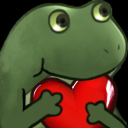